# 导入模块

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
# from jqdatasdk import *
from scipy import stats
from tqdm import tqdm, trange
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
# auth('173XXXX7314','XXXXXXXXXXX') 
os.chdir(r'E:\终生学习\算法编程\python')
from universal_function import *
# get_query_count()   

{'total': 2000000, 'spare': 2000000}

# 全局参数

In [3]:
# 路径
mainpath = r'D:\2-本科生阶段\7-毕业论文'
datapath = r'D:\2-本科生阶段\7-毕业论文' + r'\3-data'
outputpath = r'D:\2-本科生阶段\7-毕业论文' + r'\outputs'

# 时间
start_date = '20050101' # 期货数据开始时间
#end_date = datetime.date.today().strftime('%Y%m%d') # 数据结束时间
end_date = '20200423'
date = pd.date_range(start_date,end_date) # 自然日日期序列
tdate = get_trade_days(start_date,end_date) # 交易日日期序列

# 文件
datalist = os.listdir(datapath) # data目录下文件列表

# pandas显示设置
pd.options.display.max_columns = 10
pd.options.display.max_rows = 30

# 画图
plt.style.use('ggplot')

large = 32; med = 16
params = {'axes.titlesize' : large,
          'legend.fontsize' : med,
          'figure.figsize' : (16,10),
          'axes.labelsize' : med,
          'xtick.labelsize' : med,
          'ytick.labelsize' : med,
          'figure.titlesize' : large}
plt.rcParams.update(params)
plt.rcParams['font.family'] = "SimHei" # SimHei
plt.rcParams['axes.unicode_minus'] = False 

figure_writer = pd.ExcelWriter('figures.xlsx')

# 全局函数

In [4]:
def Plot_twox(df1,df2,label1=False,label2=False):
    '''
    主次坐标轴画图
    '''
    if [label1,label2] == [False,False]:
        label1=df1.columns[0];label2=df2.columns[0]
    else:
        pass
    fig,ax = plt.subplots()
    ax2 = ax.twinx()
    ax.plot(df1,'black',linewidth=2.5,label = label1)
    ax2.plot(df2,'--',linewidth=2.5,label = label2)
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(handles1+handles2, labels1+labels2, loc='upper right')
    plt.xticks()
    plt.yticks()
    plt.show()

# 下载数据

In [7]:
# get futures and options information
futures_info = get_all_securities(types=['futures'])  # 期货条款的数据
futures_info = futures_info[futures_info.display_name.str[0:2] == '豆粕']
os.chdir(datapath)
futures_info.to_csv('{}豆粕期货合约信息.csv'.format(end_date), encoding='utf-8-sig')

options_info = get_all_securities(types=['options'])
options_info = options_info[(options_info.display_name.str[1:2] != 'A')
                            & (options_info.display_name.str[0:1] == 'M')]
options_info.to_csv('{}豆粕期权合约信息.csv'.format(end_date), encoding='utf-8-sig')

# get dominant future list
## dfl is short for dominant future list
dfl = []
for i in tqdm(tdate):
    temp = get_dominant_future('M', i)
    dfl.append(temp)
dfl = pd.concat([pd.Series(tdate), pd.Series(dfl)], axis=1)
dfl.columns = ['date', 'contract_name']
dfl.to_csv('{}期货主力合约列表.csv'.format(end_date), index=False)

# making a total dataframe
# tdfl is short for trading dominant future list
tdfl = dfl[dfl.date.isin(tdate)]
tdfl.index = range(len(tdfl))
totaldf = pd.DataFrame(columns=[
    'contract_name', 'open', 'close', 'low', 'high', 'volume', 'money',
    'factor', 'high_limit', 'low_limit', 'avg', 'pre_close', 'paused',
    'open_interest'
])
for i in tqdm(range(len(tdfl))):
    tempdate = tdfl.date[i]
    enddate = pd.date_range(tempdate, periods=901, freq='min')[-1]  # 15:30收盘
    tempname = tdfl.contract_name[i]
    tempdf = get_price(tempname,
                       end_date=enddate,
                       frequency='1m',
                       count=225,
                       fields=[
                           'open', 'close', 'low', 'high', 'volume', 'money',
                           'factor', 'high_limit', 'low_limit', 'avg',
                           'pre_close', 'paused', 'open_interest'
                       ])
    tempdf.insert(0, 'contract_name', tdfl.contract_name[i])
    totaldf = totaldf.append(tempdf)

totaldf.insert(1, 'timestamp', totaldf.index)
totaldf.index = range(len(totaldf))

totaldf.insert(totaldf.shape[1], 'close_ret',
               totaldf.apply(lambda x: math.log(x.close / x.pre_close),axis=1))
totaldf.to_csv('{}期货主力合约1min数据.csv'.format(end_date), index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 3720/3720 [07:56<00:00,  7.81it/s]


In [64]:
# 期权交易量数据
from jqdatasdk import opt
optiondf = pd.DataFrame()
for temp_date in tqdm(totaldf[['call_option']].dropna().index):
    temp_option = totaldf[['call_option']].loc[temp_date][0]
    temp_option = temp_option.replace('.DCE','.XDCE')
    temp_option = temp_option.replace('-C-','-P-')
    temp_date = temp_date.strftime('%Y-%m-%d')
    q=query(opt.OPT_DAILY_PRICE).filter(opt.OPT_DAILY_PRICE.code==temp_option,opt.OPT_DAILY_PRICE.date==temp_date)
    temp = opt.run_query(q)
    optiondf = optiondf.append(temp)

100%|████████████████████████████████████████████████████████████████████████████████| 747/747 [01:35<00:00,  7.83it/s]


In [65]:
os.chdir(datapath)
optiondf.to_csv('{}看跌期权量价数据.csv'.format(end_date))

# 更新数据

In [3]:
last_upgrade_date = os.listdir(datapath)[0][0:8] # 上次更新数据时间

futures_info = get_all_securities(types=['futures'])  # 期货条款的数据
futures_info = futures_info[futures_info.display_name.str[0:2] == '豆粕']
os.chdir(datapath)
futures_info.to_csv('{}豆粕期货合约信息.csv'.format(end_date), encoding='utf-8-sig')

options_info = get_all_securities(types=['options'])
options_info = options_info[(options_info.display_name.str[1:2] != 'A')
                            & (options_info.display_name.str[0:1] == 'M')]
options_info.to_csv('{}豆粕期权合约信息.csv'.format(end_date), encoding='utf-8-sig')

dfl = pd.read_csv(datalist[1], index_col=0)
for i in pd.date_range(last_upgrade_date, end_date)[1:]:
    temp = get_dominant_future('M', i)
    temp = pd.DataFrame(temp,
                        index=[i.strftime('%Y-%m-%d')],
                        columns=['contract_name'])
    dfl = dfl.append(temp)
dfl = dfl[~dfl.index.duplicated(keep='last')] # 重复选取的保留后面的
dfl.to_csv('{}期货主力合约列表.csv'.format(end_date), encoding='utf-8-sig')

dfl = dfl.reset_index()
dfl.columns = ['date', 'contract_name']

futuredf = pd.read_csv(datalist[0])

temp = get_trade_days(last_upgrade_date,end_date)
tdfl = dfl[pd.to_datetime(dfl.date).isin(pd.to_datetime(temp))]
tdfl.index = range(len(tdfl))

totaldf = pd.DataFrame(columns=[
    'contract_name', 'open', 'close', 'low', 'high', 'volume', 'money',
    'factor', 'high_limit', 'low_limit', 'avg', 'pre_close', 'paused',
    'open_interest'
])
for i in range(len(tdfl)):
    tempdate = tdfl.date[i]
    enddate = pd.date_range(tempdate, periods=901, freq='min')[-1]  # 15:30收盘
    tempname = tdfl.contract_name[i]
    tempdf = get_price(tempname,
                       end_date=enddate,
                       frequency='1m',
                       count=225,
                       fields=[
                           'open', 'close', 'low', 'high', 'volume', 'money',
                           'factor', 'high_limit', 'low_limit', 'avg',
                           'pre_close', 'paused', 'open_interest'
                       ])
    tempdf.insert(0, 'contract_name', tdfl.contract_name[i])
    totaldf = totaldf.append(tempdf)

totaldf.insert(1, 'timestamp', totaldf.index)
totaldf.index = range(len(totaldf))
totaldf.insert(totaldf.shape[1], 'close_ret',
               totaldf.apply(lambda x: math.log(x.close / x.pre_close),axis=1))
futuredf = futuredf.append(totaldf)
futuredf.timestamp = pd.to_datetime(futuredf.timestamp)
futuredf = futuredf[~futuredf.timestamp.duplicated(keep='last')]
futuredf.to_csv('{}期货主力合约1min数据.csv'.format(end_date), index=False)

# 计算模糊性

## 读取数据

In [285]:
os.chdir(datapath)
try:
    main_future_list = pd.read_csv('{}期货主力合约列表.csv'.format(end_date))
    futuredf = pd.read_csv('{}期货主力合约1min数据.csv'.format(end_date),index_col=1)
    futuredf.index = pd.to_datetime(futuredf.index)
except:
    print('数据尚未更新到最新哦！')

# 计算5min级的收益率序列
retdf = pd.DataFrame(futuredf.close_ret)
retdf.index = pd.to_datetime(retdf.index)
retdf = retdf.resample('5min').sum()
retdf = retdf[(retdf.index.hour.isin([9,10,11,13,14]))]
retdf[(retdf.index.hour==10)&(retdf.index.minute>10)&(retdf.index.minute<30)] = np.nan
retdf[(retdf.index.hour==11)&(retdf.index.minute>25)] = np.nan
retdf[(retdf.index.hour==13)&(retdf.index.minute<30)] = np.nan
retdf[(retdf.index.hour == 9)&(retdf.index.minute==0)] = np.nan # 去除隔日交易的影响
retdf[(retdf.index.day == 16)&(retdf.index.month==3)&(retdf.index.year==2005)] = np.nan
retdf = retdf.dropna()

retdf2 = pd.DataFrame() # 剔除非交易日
for tempdate in tqdm(tdate):
    retdf2 = retdf2.append(retdf[tempdate.strftime('%Y%m%d')])
retdf = retdf2.copy()
retdf = retdf.loc['2009-10-01':,:]

100%|█████████████████████████████████████████████████████████████████████████████| 3720/3720 [00:04<00:00, 817.04it/s]


In [6]:
retdf.min()

close_ret   -0.033392
dtype: float64

In [31]:
# 看一看封停的情况有哪些
retdf[retdf.close_ret==0].resample('d').count().sort_values(by='close_ret',ascending=False)

,close_ret
timestamp,
2016-05-11,44
2010-10-11,44
2014-07-01,44
2013-08-26,44
2018-11-02,40
2010-11-17,37
2012-07-30,36
2010-09-20,35
2012-07-16,29


## 计算日频、月频模糊性

In [286]:
def Cal_ambiguity(retdf,bar,ma='m'):
    '''
    Description
    -----------
    传入期货数据，返回模糊性序列
    
    Parameters
    ----------
    retdf : n*1 dataframe
        index: 5min时间序列
        columns: 收益率

    Returns
    -------
    mhodf: n*1 dataframe
    
    '''
    if ma == 'm':
        # 得到当月数据，对月循环
        tempmonth = retdf.resample('m').count().index
        mhodf = pd.DataFrame()
        rlist = []
        temp = -0.05
        while temp <= 0.05:
            rlist.append(temp)
            temp += bar
            
        for tempmonthi in tqdm(tempmonth):
            monthdf = retdf[tempmonthi.strftime('%Y-%m')]
            ## 得到当天数据，对天循环
            tempdate = monthdf.resample('d').count().index
            promonthdf = pd.DataFrame()
            for tempdatei in tempdate:
                daydf = monthdf.loc[tempdatei.strftime('%Y%m%d')] # 每天的数据算均值标准差
                if daydf[daydf.close_ret==0].count()[0] > 22:
                    continue
                ## 对r循环，得到每天对应r的均值标准差
                prodaydf = pd.DataFrame(columns = ['r','mean','sigma'])
                tempmean = daydf.mean()[0]
                tempstd = daydf.std()[0]
                if tempstd == 0:
                    continue
                tempdf = pd.DataFrame()
                tempdf.insert(0,'r',rlist)
                tempdf.insert(1,'mean',tempmean)
                tempdf.insert(2,'sigma',tempstd)
                prodaydf = prodaydf.append(tempdf)
                prodaydf.insert(0,'date',tempdatei)
                prodaydf = prodaydf.replace(0,np.nan)
                prodaydf.dropna(inplace=True)
                cumprob = stats.norm.cdf(prodaydf.iloc[:,1],prodaydf.iloc[:,2],prodaydf.iloc[:,3])
                prodaydf.insert(4,'cumprob',cumprob)
                prodaydf.insert(5,'prob',prodaydf.cumprob.diff())
                try:
                    prodaydf.iloc[0,5] = cumprob[0]
                    prodaydf.iloc[-1,5] = 1 - cumprob[-1]
                except:
                    pass
                promonthdf = promonthdf.append(prodaydf)
            meanprob = pd.DataFrame(promonthdf.groupby('r').mean().iloc[:,-1])
            varprob = pd.DataFrame(promonthdf.groupby('r').std().iloc[:,-1] ** 2)
            mho2 = 1 / bar / (1-bar) * np.dot(meanprob.values.T,varprob.values)[0,0]
            tempdf = pd.DataFrame([mho2],index=[tempmonthi],columns=['ambiguity'])
            mhodf = mhodf.append(tempdf)
    
    else:
        mhodf = pd.DataFrame()
        window_begin = 1160 # 1215从2010-01-04开始
        window_end = window_begin + ma - 1
        rlist = []
        temp = -0.05
        while temp <= 0.05:
            rlist.append(temp)
            temp += bar
        
        for window_end in trange(window_end,len(tdate)):
            temp_window = retdf[tdate[window_begin].strftime('%Y-%m-%d'):tdate[window_end].strftime('%Y-%m-%d')]
            if len(temp_window) == 0:
                break
            ## 得到当天数据，对天循环
            tempdate = temp_window.resample('d').count().index
            promonthdf = pd.DataFrame() # 储存本窗口期的数据
            for tempdatei in tempdate:
                daydf = temp_window.loc[tempdatei.strftime('%Y%m%d')]
                if daydf[daydf.close_ret==0].count()[0] > 22:
                    continue
                ## 对r循环，得到每天对应r的均值标准差
                prodaydf = pd.DataFrame(columns = ['r','mean','sigma']) # 存放单日分布数据
                tempmean = daydf.mean()[0]
                tempstd = daydf.std()[0]
                tempdf = pd.DataFrame()
                tempdf.insert(0,'r',rlist)
                tempdf.insert(1,'mean',tempmean)
                tempdf.insert(2,'sigma',tempstd)
                prodaydf = prodaydf.append(tempdf)
                prodaydf.insert(0,'date',tempdatei)
                prodaydf = prodaydf.replace(0,np.nan)
                prodaydf.dropna(inplace=True)
                cumprob = stats.norm.cdf(prodaydf.iloc[:,1],prodaydf.iloc[:,2],prodaydf.iloc[:,3])
                prodaydf.insert(4,'cumprob',cumprob)
                prodaydf.insert(5,'prob',prodaydf.cumprob.diff())
                try: # 将diff带来的缺失值给填充上去
                    prodaydf.iloc[0,5] = cumprob[0]
                    prodaydf.iloc[-1,5] = 1 - cumprob[-1]
                except:
                    pass
                promonthdf = promonthdf.append(prodaydf)
            meanprob = pd.DataFrame(promonthdf.groupby('r').mean().iloc[:,-1])
            varprob = pd.DataFrame(promonthdf.groupby('r').std().iloc[:,-1] ** 2)
            mho2 = 1 / bar / (1-bar) * np.dot(meanprob.values.T,varprob.values)[0,0]
            tempdf = pd.DataFrame([mho2],index=[tdate[window_end]],columns=['ambiguity'])
            mhodf = mhodf.append(tempdf)
            window_begin += 1
    return mhodf

100%|████████████████████████████████████████████████████████████████████████████████| 184/184 [01:20<00:00,  2.29it/s]


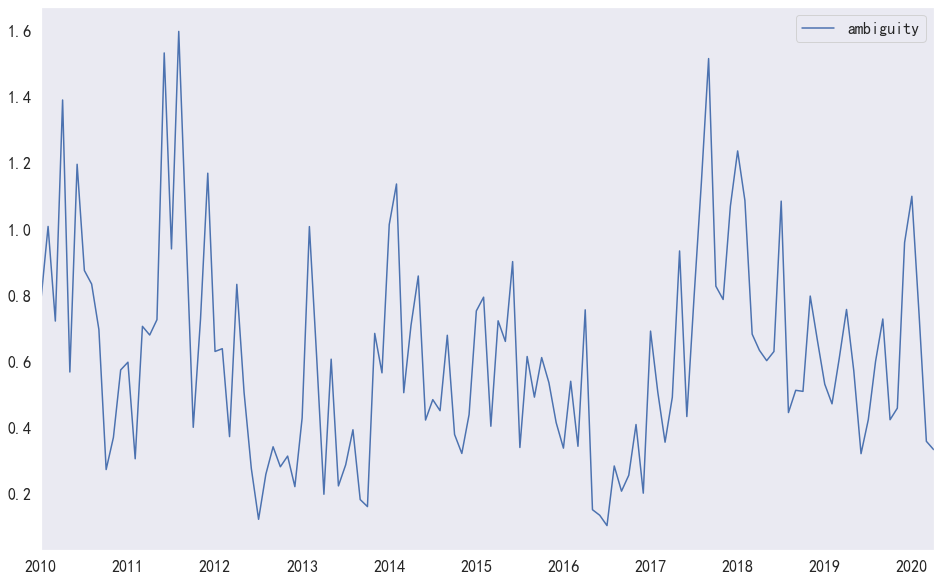

In [111]:
# 月频
mmhodf = Cal_ambiguity(retdf,bar=0.0001,ma='m')
os.chdir(outputpath)
mmhodf = mmhodf[mmhodf.index.year>2009]
mmhodf.plot()
mmhodf.to_csv('{}月频模糊性数据.csv'.format(end_date))

In [ ]:
# 日频 ma22
dmhodf22 = Cal_ambiguity(retdf,bar=0.0001,ma=22)
os.chdir(outputpath)
dmhodf22.index = pd.to_datetime(dmhodf22.index)
dmhodf22 = dmhodf22.loc['2010':]
dmhodf22.plot()
dmhodf22.to_csv('{}ma22日频模糊性数据.csv'.format(end_date))

100%|██████████████████████████████████████████████████████████████████████████████| 2556/2556 [05:15<00:00,  8.09it/s]


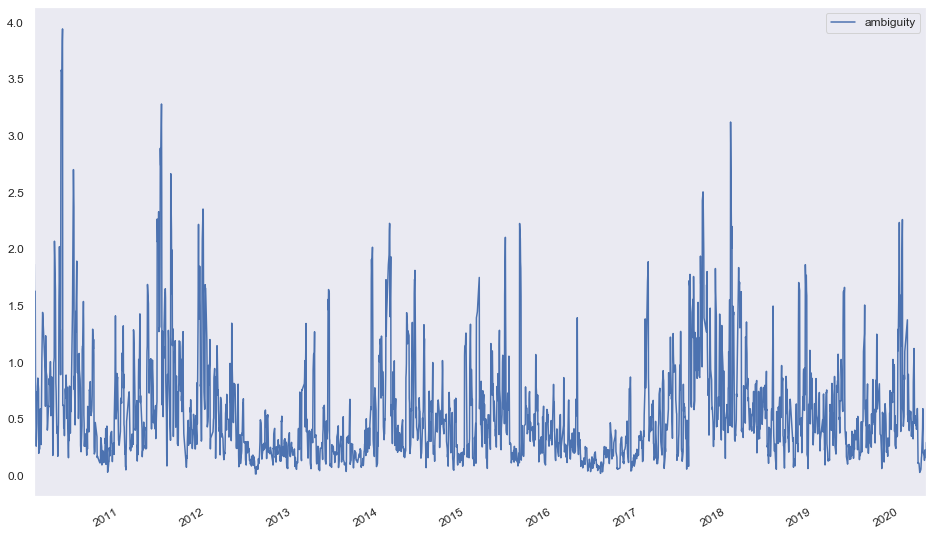

In [287]:
# 日频 ma22
dmhodf5 = Cal_ambiguity(retdf,bar=0.0001,ma=5)
os.chdir(outputpath)
dmhodf5.index = pd.to_datetime(dmhodf5.index)
dmhodf5 = dmhodf5.loc['2010':]
dmhodf5.plot()
dmhodf5.to_csv('{}ma5日频模糊性数据.csv'.format(end_date))